<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L26-GraphNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network

In this notebook we will explore the training of a graph neural network based on the features of the nodes and a graph neural network with the adjacency matrix. In order to show that applying the model with an adjacency matrix is better than another one in performance metrics.

## Install and import packages

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

## Load dataset



[The Cora dataset](https://ojs.aaai.org/aimagazine/index.php/aimagazine/article/view/2157) introduced by Sen et al. in 2008, Cora (no license) is the most popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications, where each connection is a reference. Each publication is described as a binary vector of 1,433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word, respectively. This representation is also called a binary bag of words in natural language processing. Our goal is to classify each node into one of seven categories.

Regardless of the type of data, visualization is always an important step to getting a good grasp of the problem we face. However, graphs can quickly become too big to visualize using Python libraries such as networkx. This is why dedicated tools have been developed specifically for graph data visualization. We utilize two of the most popular ones: yEd Live (https://www.yworks.com/yed-live/) and Gephi (https://gephi.org/).

The following figure is a plot of the Cora dataset made with yEd Live. You can see nodes corresponding to papers in orange and connections between them in green. Some papers are so interconnected that they form clusters. These clusters should be easier to classify than poorly connected nodes.

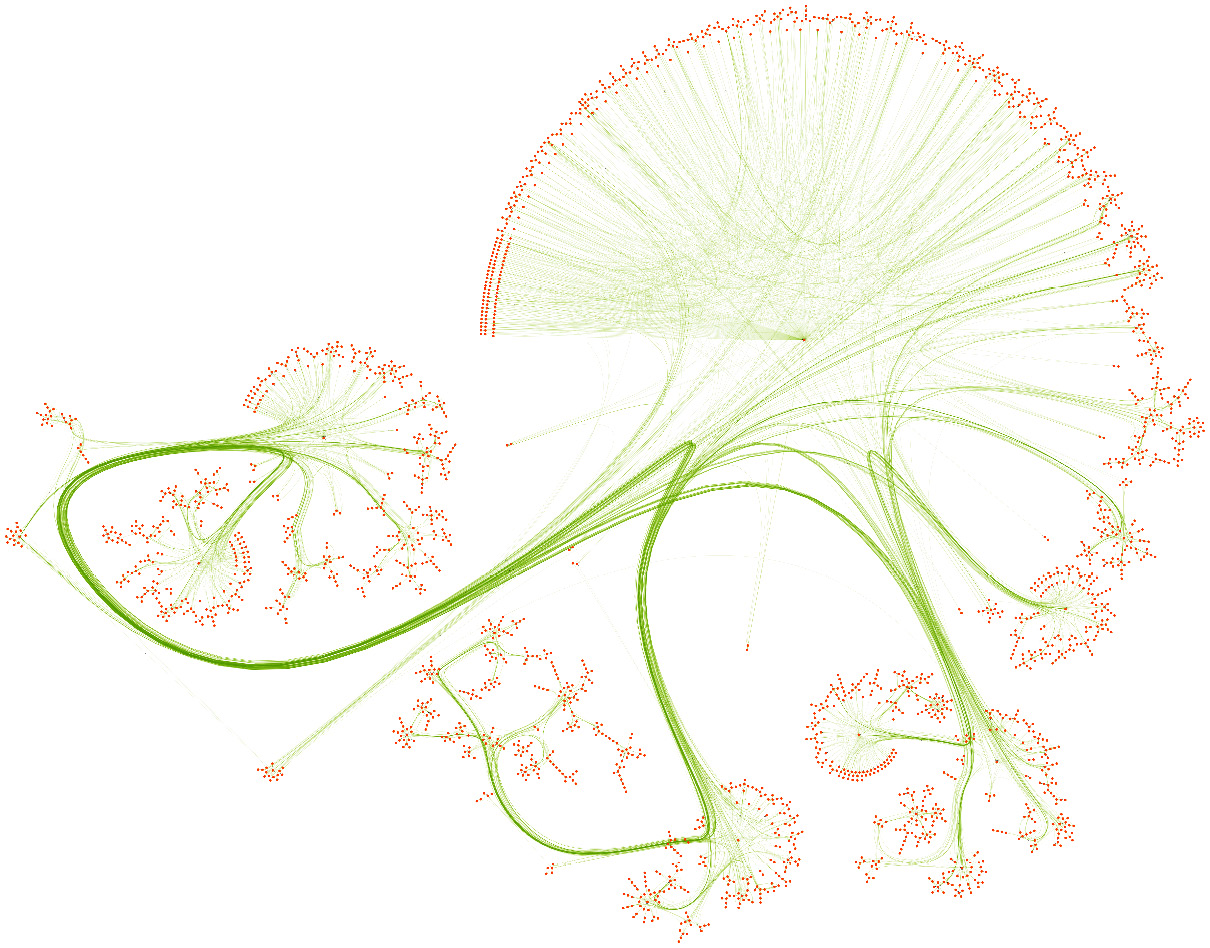

In [ ]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


Done!


### From Tensor to DataFrame

In [20]:
# Tensor with edge index
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [21]:
# From Tensor to Numpy array
data.edge_index.numpy()

array([[   0,    0,    0, ..., 2707, 2707, 2707],
       [ 633, 1862, 2582, ...,  598, 1473, 2706]])

In [22]:
# From Tensor to DataFrame
pd.DataFrame(data.edge_index.numpy())

,0,1,2,3,4,5,6,7,8,9,...,10546,10547,10548,10549,10550,10551,10552,10553,10554,10555
0,0,0,0,1,1,1,2,2,2,2,...,2704,2705,2706,2706,2706,2706,2707,2707,2707,2707
1,633,1862,2582,2,652,654,1,332,1454,1666,...,641,287,165,169,1473,2707,165,598,1473,2706


In [23]:
# Final transformation
pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

,start_node,end_node
0,0,633
1,0,1862
2,0,2582
3,1,2
4,1,652
...,...,...
10551,2706,2707
10552,2707,165
10553,2707,598
10554,2707,1473


### Visualizing the graph

In [24]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [25]:
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")

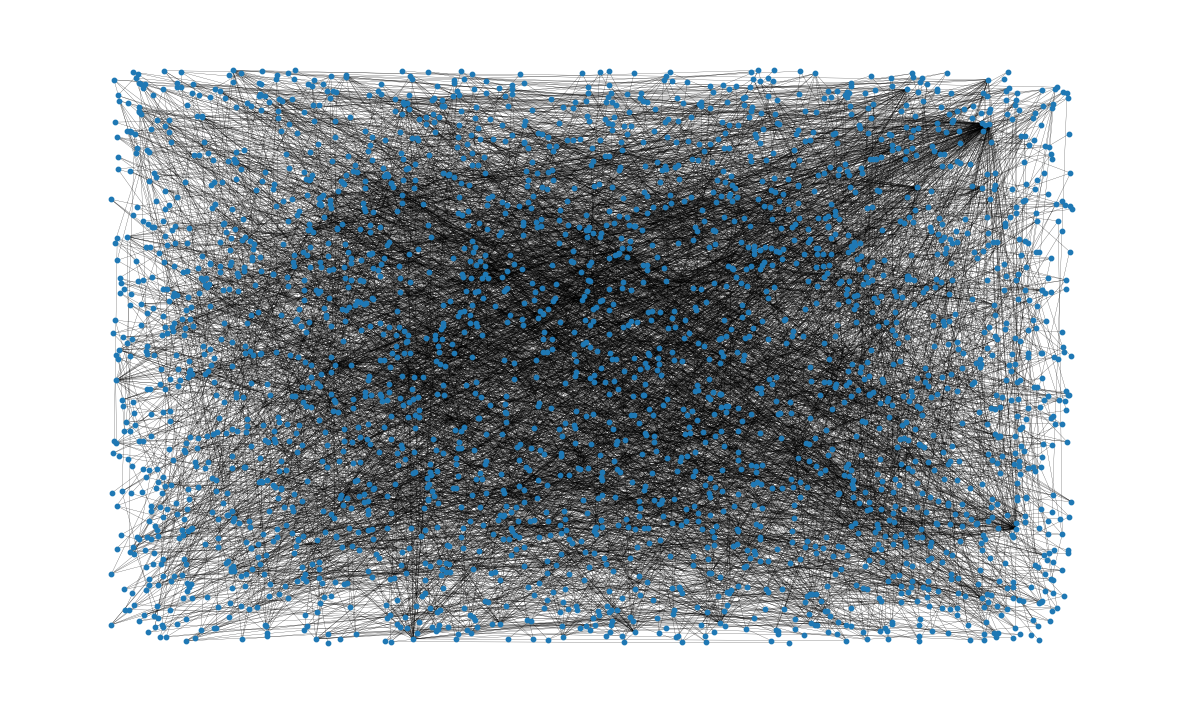

In [26]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

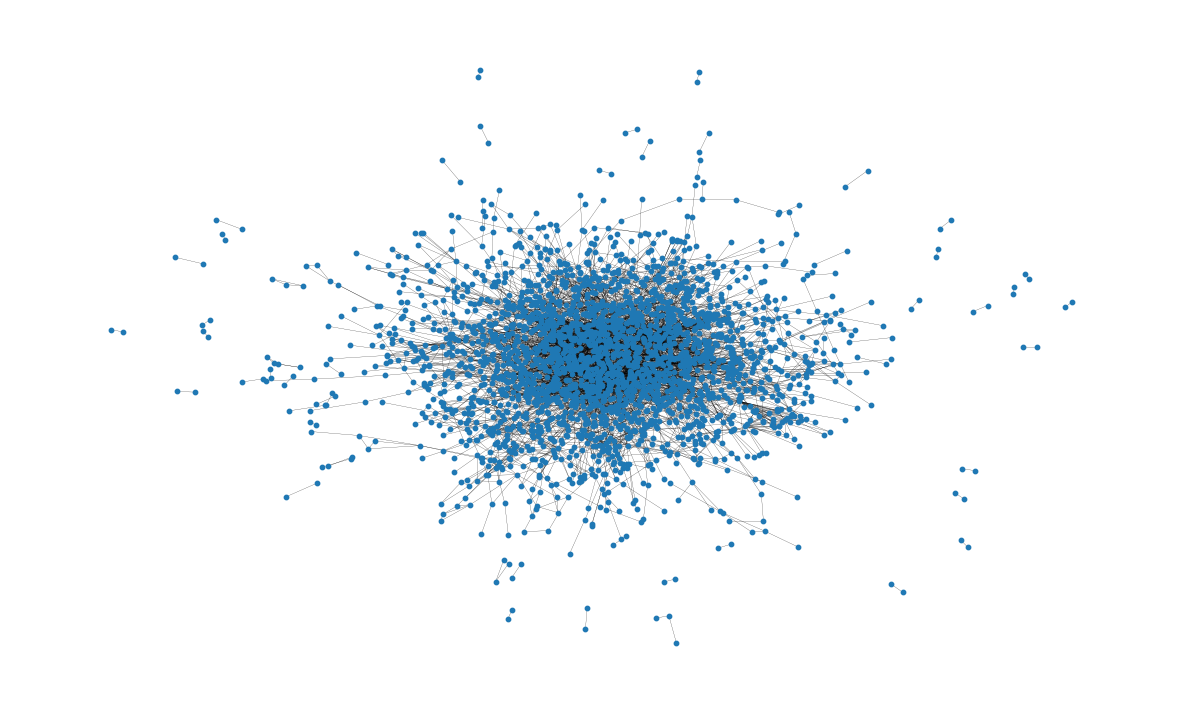

In [27]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [36]:
# Filtering at least three connections
edge_index_list_filtered = edge_index_list.groupby("start_node").filter(lambda x: len(x) > 3)
edge_index_list_filtered.head()

,start_node,end_node
6,2,1
7,2,332
8,2,1454
9,2,1666
10,2,1986


In [37]:
G = nx.from_pandas_edgelist(edge_index_list_filtered, "start_node", "end_node")

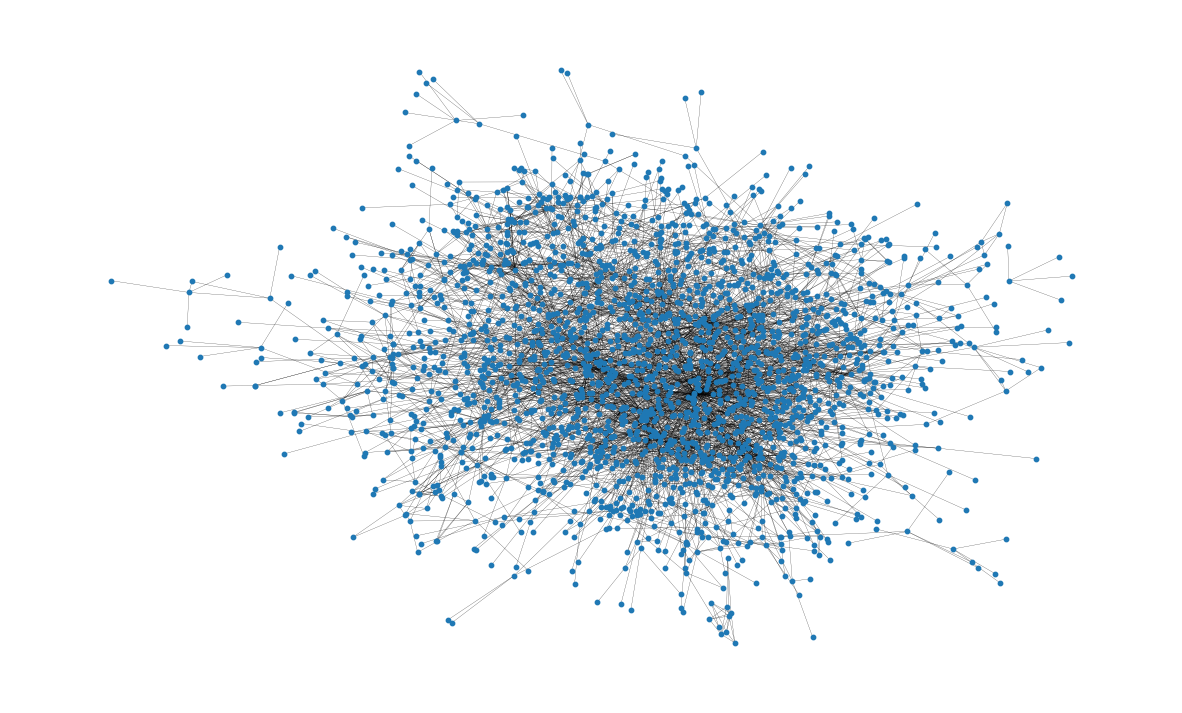

In [38]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

## MLP in Cora dataset with feature nodes

In [ ]:
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create MLP model
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.959 | Train Acc: 14.29% | Val Loss: 2.00 | Val Acc: 12.40%
Epoch  20 | Train Loss: 0.110 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 49.40%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 51.00%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 53.80%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.37 | Val Acc: 55.40%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.34 | Val Acc: 54.60%

MLP test accuracy: 53.40%


## GNN with Adjacency Matrix

In [ ]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency)) # A 2-D tensor with ones on the diagonal and zeros elsewhere
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [ ]:
class SparseLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [ ]:
class GNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = SparseLayer(dim_in, dim_h)
        self.gnn2 = SparseLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gnn = GNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 1.991 | Train Acc: 15.71% | Val Loss: 2.11 | Val Acc: 9.40%
Epoch  20 | Train Loss: 0.065 | Train Acc: 99.29% | Val Loss: 1.47 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 2.11 | Val Acc: 75.40%
Epoch  60 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 2.22 | Val Acc: 75.40%
Epoch  80 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 76.80%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.19 | Val Acc: 77.00%

GNN test accuracy: 76.60%
